<a href="https://colab.research.google.com/github/Akbar453/chessboard-analysis/blob/main/Chessboard_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install OpenCV in case it's not already installed
!pip install opencv-python-headless numpy matplotlib

# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt



## Image Acquisition
Upload chessboard images for analysis


In [3]:
from google.colab import files

# Upload images
uploaded = files.upload()

# Load the uploaded images into OpenCV
image_paths = list(uploaded.keys())
images = [cv2.imread(img_path) for img_path in image_paths]


Saving chessboard3.jpg to chessboard3 (1).jpg
Saving chessboard2.jpg to chessboard2 (1).jpg
Saving chessboard1.jpg to chessboard1 (1).jpg


3**. Preprocessing**
  Handle normalization, contrast adjustment, and perspective correction.

In [8]:
def preprocess_image(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Normalize lighting using adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    normalized = clahe.apply(gray)

    # Remove noise using Gaussian Blur
    blurred = cv2.GaussianBlur(normalized, (5, 5), 0)

    return blurred

preprocessed_images = [preprocess_image(img) for img in images]


4. Perspective Correction
   :Fix skewed chessboards.

In [9]:
def correct_perspective(image):
    # Detect edges using Canny
    edges = cv2.Canny(image, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    # Approximate the polygon
    epsilon = 0.02 * cv2.arcLength(largest_contour, True)
    corners = cv2.approxPolyDP(largest_contour, epsilon, True)

    if len(corners) == 4:  # If a quadrilateral is found
        corners = np.float32([corner[0] for corner in corners])

        # Define target dimensions
        width, height = 500, 500
        dst = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

        # Perform perspective transform
        matrix = cv2.getPerspectiveTransform(corners, dst)
        corrected_image = cv2.warpPerspective(image, matrix, (width, height))

        return corrected_image
    else:
        return image  # Return original if perspective correction is not possible

corrected_images = [correct_perspective(img) for img in preprocessed_images]


5. **Square Detection**
  Segment the chessboard and classify squares as black or white.  

In [10]:
def detect_squares(image):
    # Threshold the image to create a binary mask
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Detect contours of squares
    contours, _ = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    square_count = 0
    black_count, white_count = 0, 0

    for contour in contours:
        # Filter contours by size to exclude noise
        area = cv2.contourArea(contour)
        if 1000 < area < 5000:  # Adjust these thresholds as needed
            square_count += 1

            # Get the mean color inside the square
            mask = np.zeros_like(binary)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_color = cv2.mean(image, mask=mask)[0]

            if mean_color < 128:  # Classify as black or white
                black_count += 1
            else:
                white_count += 1

    return square_count, black_count, white_count, binary

results = [detect_squares(img) for img in corrected_images]


6. **Validation and Visualization**
Display results with annotated images.


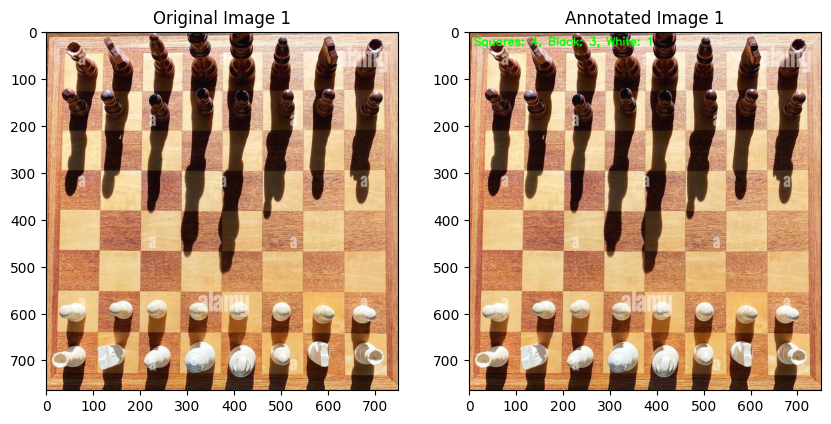

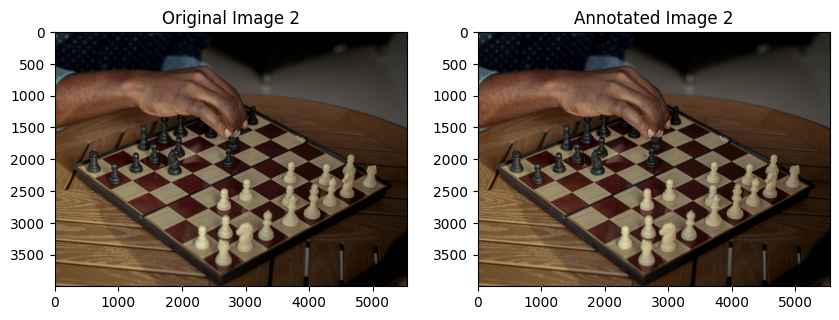

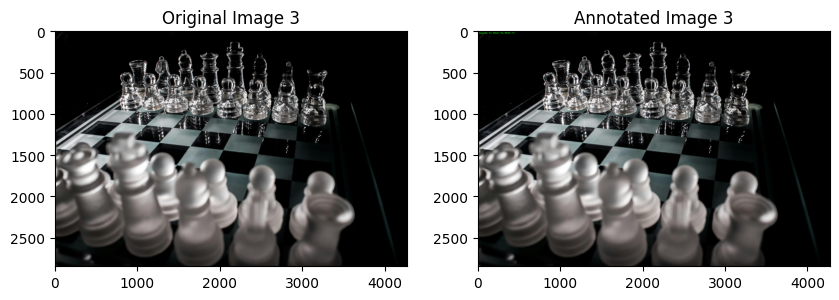

In [7]:
def annotate_image(image, result):
    square_count, black_count, white_count, binary = result

    # Overlay results on the original image
    annotated = cv2.putText(
        image.copy(),
        f"Squares: {square_count}, Black: {black_count}, White: {white_count}",
        (10, 30),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.8,
        (0, 255, 0),
        2
    )
    return annotated

for i, (img, result) in enumerate(zip(images, results)):
    annotated = annotate_image(img, result)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image {i+1}")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.title(f"Annotated Image {i+1}")
    plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
    plt.show()
